# Train script for Ladder VAE model

### imports

In [1]:
%matplotlib inline

from torch.autograd import Variable
from torch import optim
from torch.utils.data import DataLoader
import torch

import sys
sys.path.append("../../Modules")
sys.path.append("../../Datasets")

# local imports
from train import train_twitter
from helpers import nll_loss
from models import LadderVAE
from babelDatasets.sentiment140 import Sentiment140
from babelDatasets.utils import padding_merge

## Define dataset loader

In [2]:
batch_size = 32

data_loader = DataLoader(Sentiment140(data_directory="../../Datasets/Data",train=True,max_sentence_size=32),batch_size=batch_size,shuffle=True,collate_fn=padding_merge)
valid_data_loader = DataLoader(Sentiment140(data_directory="../../Datasets/Data",train=False,max_sentence_size=32),batch_size=batch_size,shuffle=True,collate_fn=padding_merge)

num_classes = 82

batch_loader = iter(data_loader)
valid_batch_loader = iter(valid_data_loader)
# input has shape [batch_size,seq_len,1]

# N sents: 150000  train: True  sentences_path: ../../Datasets/Data/train_sentences.txt
# N sents: 52990  train: False  sentences_path: ../../Datasets/Data/test_sentences.txt


## Define model

In [3]:
model = LadderVAE(input_size=1,hidden_sizes=[512,256,128,64,32],latent_sizes=[128,64,32,16,8],recon_hidden_size=256,output_size=num_classes,use_softmax=True)
print("Number of trainable parameters {}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# test forward pass
try:
    initial_batch = batch_loader.next()[0]
    x = Variable(torch.FloatTensor(initial_batch)).transpose(1,0).unsqueeze(2)
    test,_ = model(x)
    assert (test.shape[0] == x.shape[0] and test.shape[1] == x.shape[1] and test.shape[2] == num_classes)
    print("Forward pass succesfull")
except:
    print("Error in forward pass. Output should have shape: {} but had {}".format(x.contiguous().view(-1).shape,test.view(-1).shape))

Number of trainable parameters 1244194
Forward pass succesfull


## Define optimizer and loss

In [4]:
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode="min",factor=0.5,verbose=True,cooldown=2)

## Run trainer


Train (1 5%) elbo: -1.1996 r_loss: -1.1996 kl: 102292.4744 aux_loss: 0.0000 beta 0.00e+00
Valid (1 5%) elbo: -1.0265 r_loss: -1.0265 kl: 454415.1875 aux_loss: 0.0000 beta 0.00e+00

Train (2 10%) elbo: -2.2556 r_loss: -1.0255 kl: 2337.0793 aux_loss: 0.0000 beta 5.26e-04
Valid (2 10%) elbo: -0.9368 r_loss: -0.7821 kl: 293.9866 aux_loss: 0.0000 beta 5.26e-04

Train (3 15%) elbo: -0.9059 r_loss: -0.6986 kl: 196.8871 aux_loss: 0.0000 beta 1.05e-03
Valid (3 15%) elbo: -1.2435 r_loss: -1.0812 kl: 154.1879 aux_loss: 0.0000 beta 1.05e-03

Train (4 20%) elbo: -0.7889 r_loss: -0.5957 kl: 122.3997 aux_loss: 0.0000 beta 1.58e-03
Valid (4 20%) elbo: -1.0582 r_loss: -0.8840 kl: 110.3741 aux_loss: 0.0000 beta 1.58e-03

Train (5 25%) elbo: -0.7583 r_loss: -0.5398 kl: 103.7619 aux_loss: 0.0000 beta 2.11e-03
Valid (5 25%) elbo: -0.7441 r_loss: -0.5132 kl: 109.6537 aux_loss: 0.0000 beta 2.11e-03

Train (6 30%) elbo: -0.7610 r_loss: -0.5081 kl: 96.1064 aux_loss: 0.0000 beta 2.63e-03
Valid (6 30%) elbo: -4

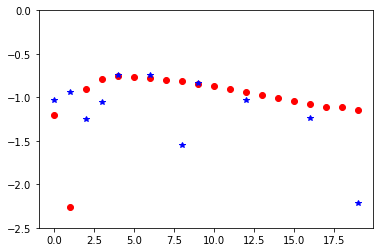

In [5]:
# use at least 50 iterations to get good results
train_twitter(data_loader,valid_data_loader,model,optimizer,scheduler,loss_fn=nll_loss,kl_loss_fn=None,n_iters=20,use_softmax=True,max_beta=1e-2,print_every=1,plot_pred=False,max_batches=3000)

In [8]:
#torch.save(model.state_dict(),"../../Saved_models/Sentiment140/LVAE_nll_map_5l.pt")

with this setting: hidden_sizes=[512,256,128],latent_sizes=[64,32,16],recon_hidden_size=256

Train (20 100%) elbo: -1.1589 r_loss: -0.4739 kl: 68.4986 aux_loss: 0.0000 beta 1.00e-02

Valid (20 100%) elbo: -1.2723 r_loss: -0.5495 kl: 72.2757 aux_loss: 0.0000 beta 1.00e-02

and with this hidden_sizes=[512,256,128,64,32],latent_sizes=[128,64,32,16,8],recon_hidden_size=256

Train (20 100%) elbo: -1.1418 r_loss: -0.4507 kl: 69.1106 aux_loss: 0.0000 beta 1.00e-02

Valid (20 100%) elbo: -2.2134 r_loss: -1.5351 kl: 67.8305 aux_loss: 0.0000 beta 1.00e-02